# 내일의 주식

### 내일의 삼성전자

- [데이터셋](https://finance.yahoo.com/)
- 005930.KS.csv

## 1. 데이터 준비

- Columns: Date, Open, High, Low, Close, Adj Close, Volume
- 위 중 Close(종가)만 사용

In [2]:
import math
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')
dir_path = 'drive/My Drive/Colab Notebooks/E14_time_series_prediction'

Mounted at /content/drive


In [ ]:
# Load dataset
dir_path = os.getenv('HOME') + '/aiffel/aiffel_projects/exploration/E14_stock_prediction/data/005930.KS.csv'

df = pd.read_csv(dir_path, index_col='Date', parse_dates=True, error_bad_lines=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [ ]:
# Time Series 생성
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

<hr>

## 2. Stationary 정성적 분석

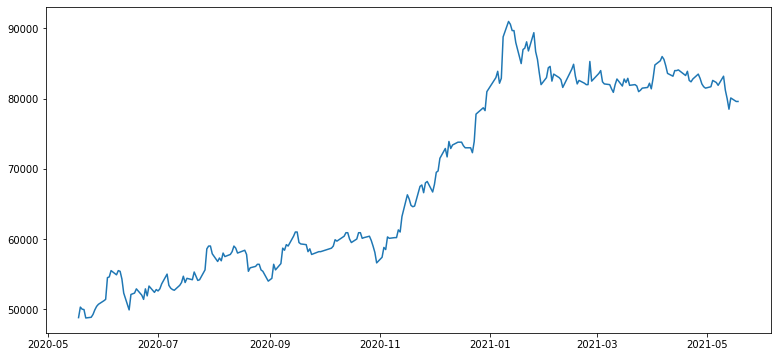

In [ ]:
plt.plot(ts)

In [ ]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [ ]:
# 결측치 없으므로 생략
#ts = ts.interpolate(mehod='time')
#ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
  # 이동 평균 시계열
  rolmean = timeseries.rolling(window=window).mean()
  # 이동 표준편차 시계열
  rolstd = timeseries.rolling(window=window).std()
  # 원본, 이동평균, 이동표준편차를 plot
  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')

  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

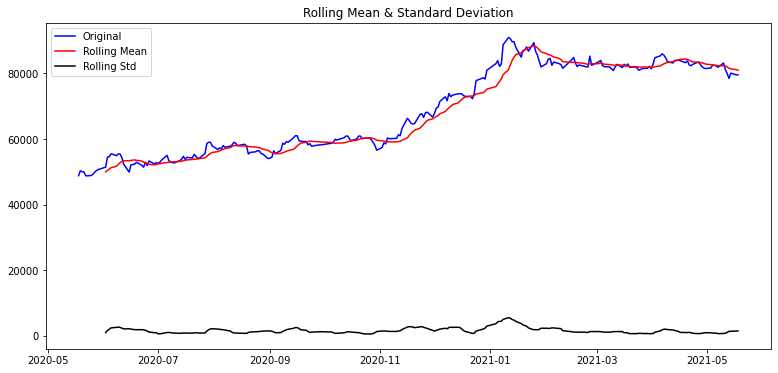

In [ ]:
plot_rolling_statistics(ts)

<br>

## 3. Stationary 정량적 분석

In [5]:
def augmented_dickey_fuller_test(timeseries):
  # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출한다.
  dftest = adfuller(timeseries, autolag='AIC')

  # adfuller 메서드가 리턴한 결과를 정리해 출력
  print('Results of Dickey-Fuller Test:')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  print(dfoutput)

In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### p-value가 0.05보다 훨씬 크므로, 귀무가설 채택

- stationary하게 만들기 위해,
- 1) 로그 변환,
- 2) 시계열 분해 기법 적용

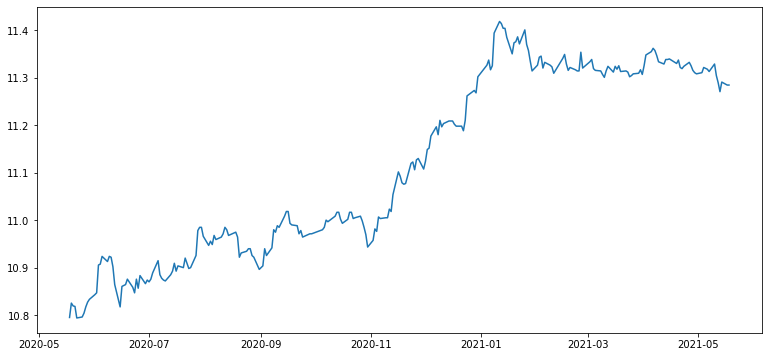

In [ ]:
ts_log = np.log(ts)

plt.plot(ts_log)

In [ ]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


#### p-value가 아주 조금 줄었지만, 여전히 크다.

- 또 시간 추이에 따라 평균이 계속 증가한다는 문제가 있다.

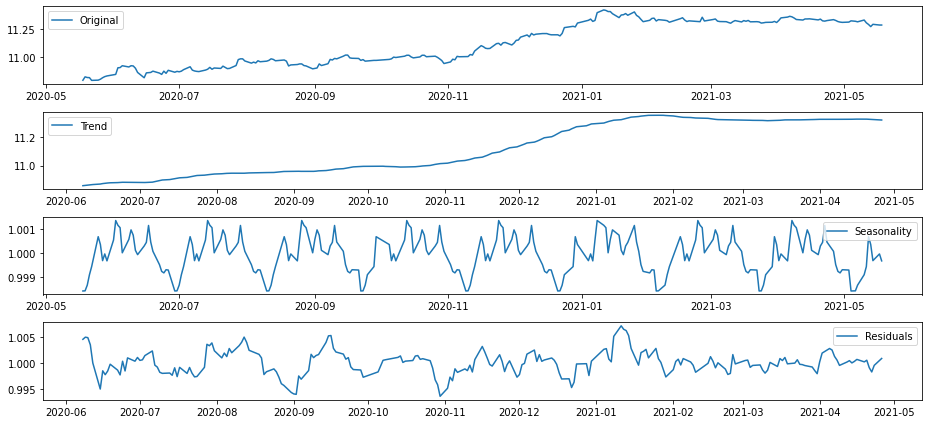

In [ ]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

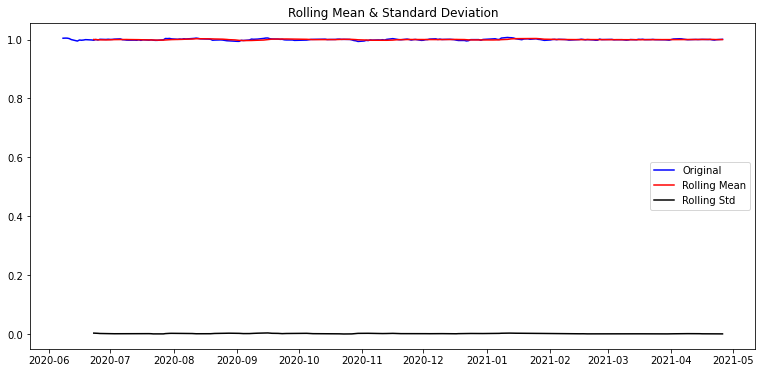

In [ ]:
plot_rolling_statistics(residual)

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


#### Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다.

- 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

<hr>

## 4. 데이터셋 분리

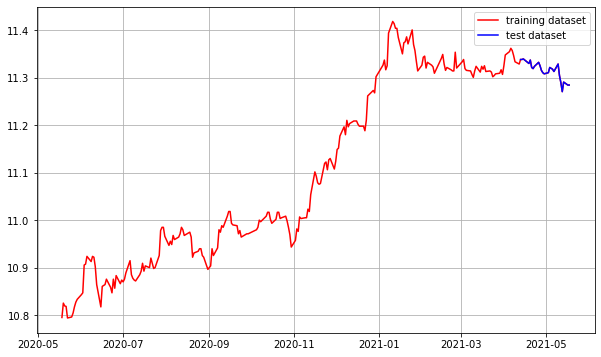

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [ ]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


## 5. ARIMA 모수 찾기

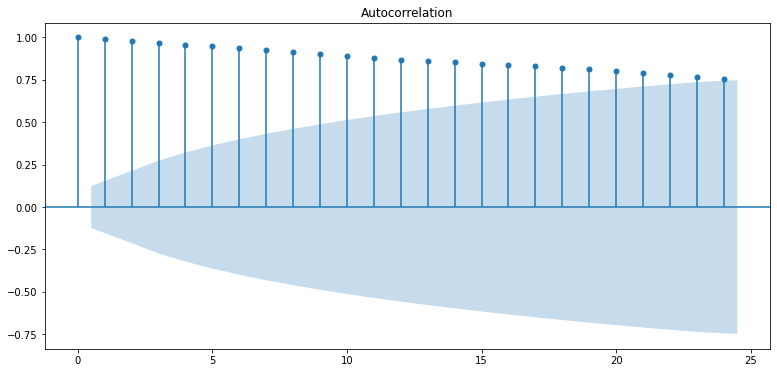

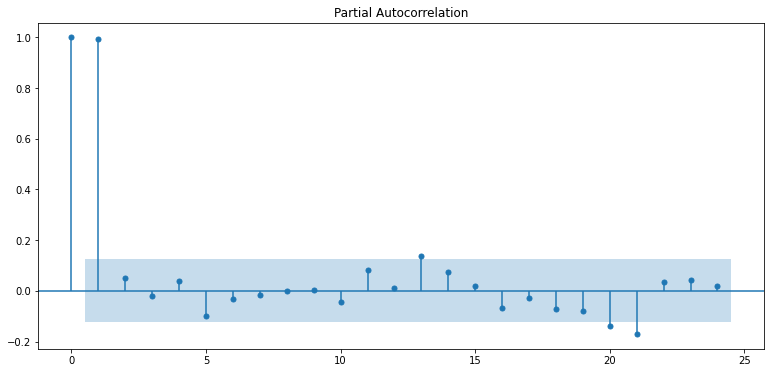

In [ ]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

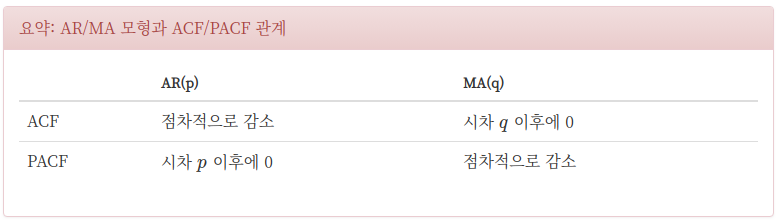

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


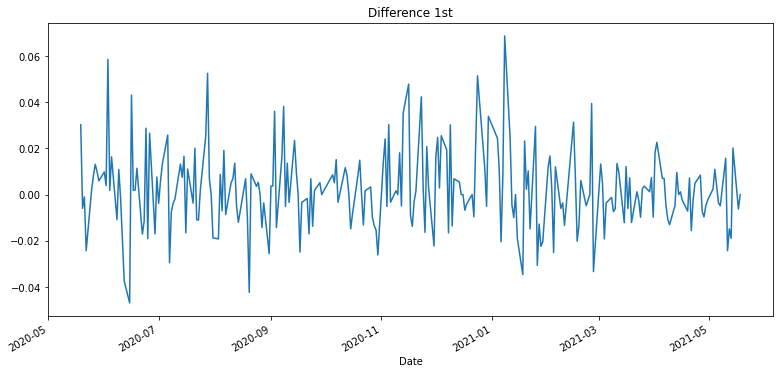

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


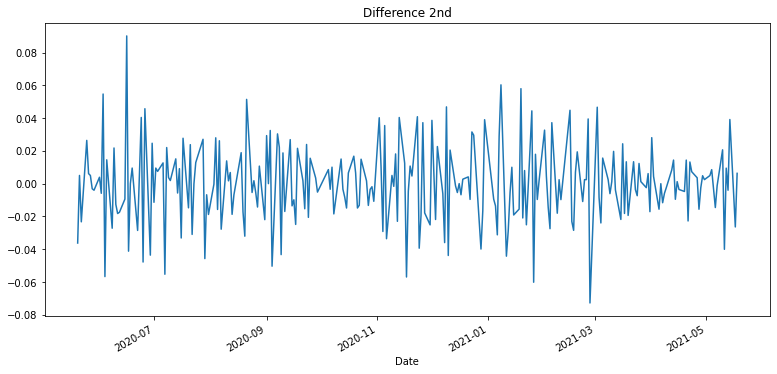

In [ ]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

이번 경우에는 1차 차분을 구했을 때 약간 애매한 수준의 안정화 상태를 보였습니다.

2차 차분을 구했을 때는 확실히 안정화 상태였지만 이번 경우에는 d=1로 먼저 시도해 볼 수 있을 것 같습니다.

d 값도 바꿔 가면서 최적의 값을 찾아보기를 권합니다.

## 6. ARIMA 모델 훈련 및 예측

In [ ]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sun, 05 Sep 2021   AIC                          -1164.792
Time:                        05:03:13   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

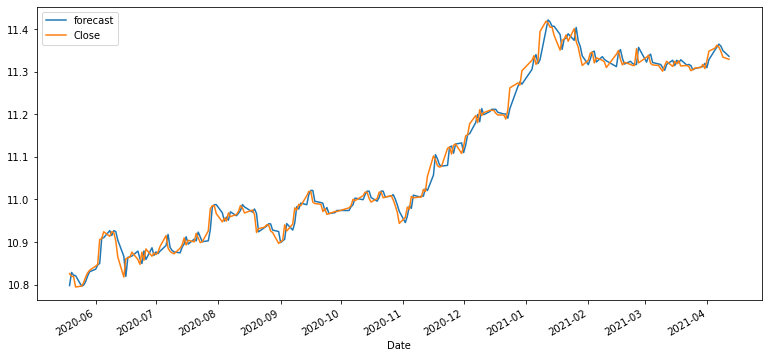

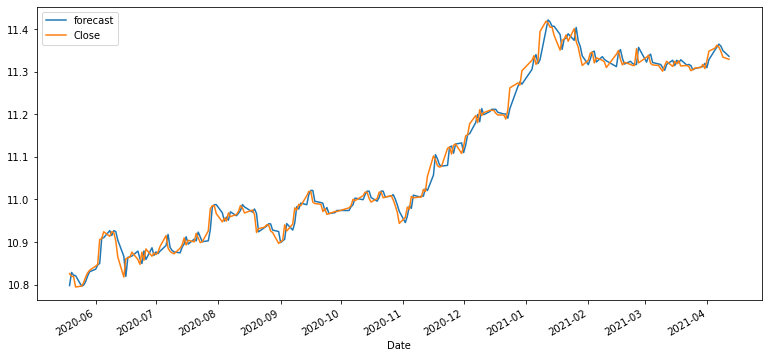

In [ ]:
fitted_m.plot_predict()

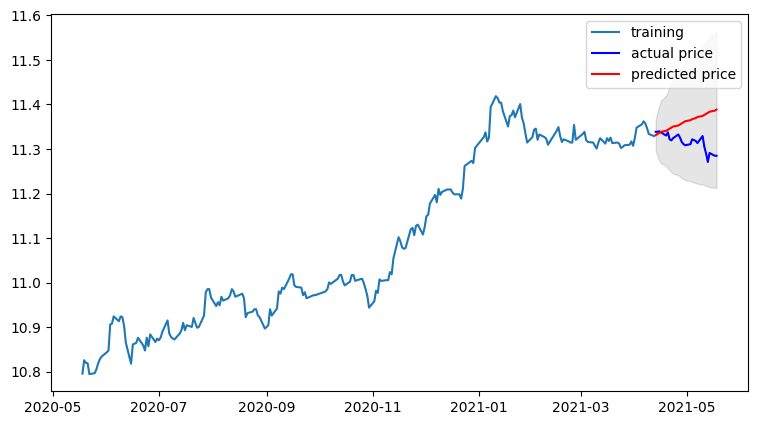

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
# 로그 변환된 시계열을 지수 변환하여 원본 스케일로 되돌리고 모델의 오차율 계산
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


<hr>

## 내일의 구글(알파벳)

In [ ]:
file_path = os.path.join(dir_path, 'GOOG.csv')

df_google = pd.read_csv(file_path, index_col='Date', parse_dates=True, error_bad_lines=False)
df_google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-04,1624.260010,1645.109985,1547.613037,1591.040039,1591.040039,2608600
2020-09-08,1533.510010,1563.864990,1528.010010,1532.390015,1532.390015,2610900
2020-09-09,1557.530029,1569.000000,1536.051025,1556.959961,1556.959961,1774700
2020-09-10,1560.640015,1584.081055,1525.805054,1532.020020,1532.020020,1618600
2020-09-11,1536.000000,1575.199951,1497.359985,1520.719971,1520.719971,1597100


In [ ]:
ts_google = df_google['Close']

ts_google.head()

Date
2020-09-04    1591.040039
2020-09-08    1532.390015
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
Name: Close, dtype: float64

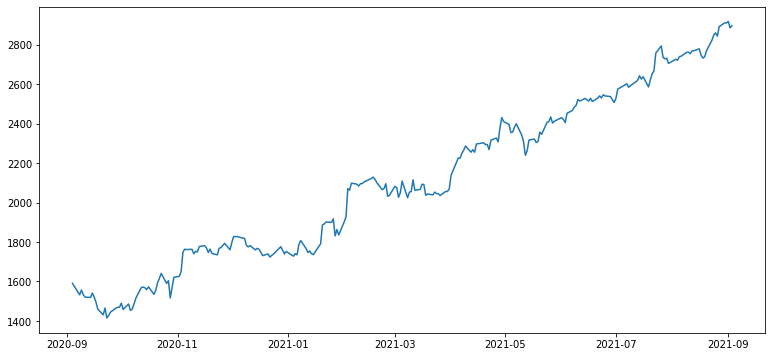

In [ ]:
plt.plot(ts_google)

In [ ]:
ts_google[ts_google.isna()]

Series([], Name: Close, dtype: float64)

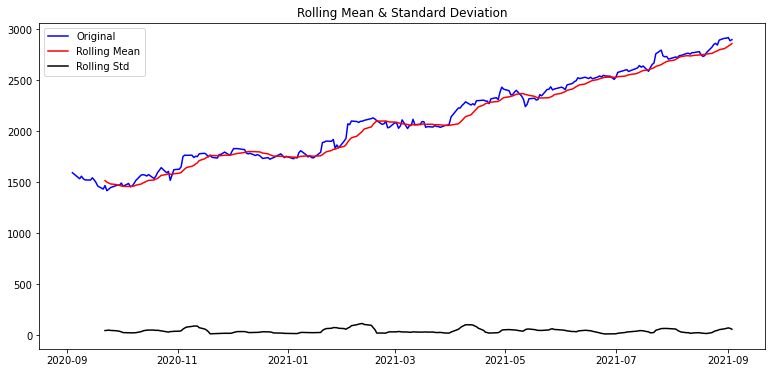

In [ ]:
plot_rolling_statistics(ts_google)

In [ ]:
augmented_dickey_fuller_test(ts_google)

Results of Dickey-Fuller Test:
Test Statistic                   0.432371
p-value                          0.982666
#Lags Used                       5.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


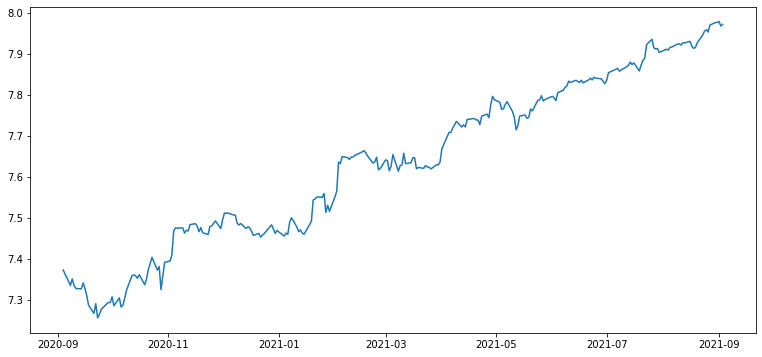

In [ ]:
ts_google_log = np.log(ts_google)

plt.plot(ts_google_log)

In [ ]:
augmented_dickey_fuller_test(ts_google_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.353143
p-value                          0.917633
#Lags Used                       7.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


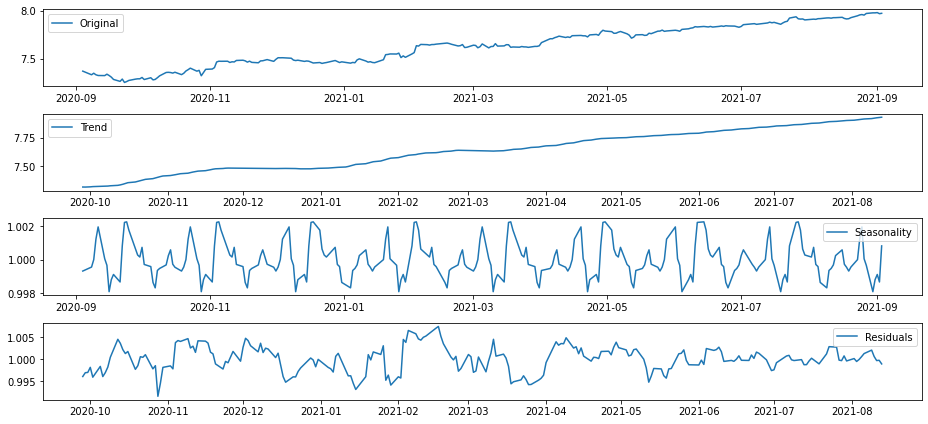

In [ ]:
decomposition = seasonal_decompose(ts_google_log, model='multiplicative', freq=30)

trend_google = decomposition.trend
seasonal_google = decomposition.seasonal
residual_google = decomposition.resid

plt.subplot(411)
plt.plot(ts_google_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_google, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_google,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_google, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

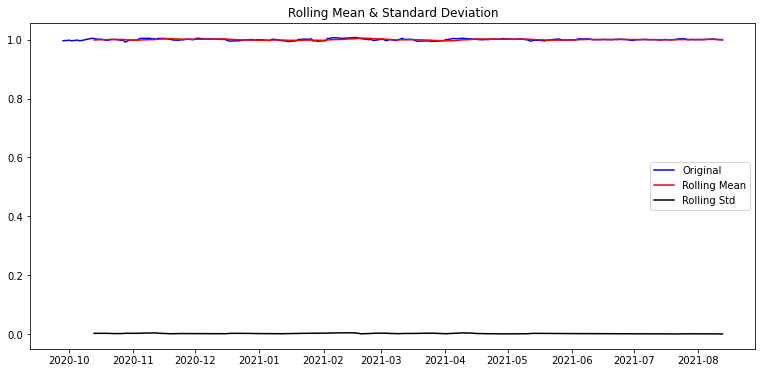

In [ ]:
plot_rolling_statistics(residual_google)

In [ ]:
residual_google.dropna(inplace=True)
augmented_dickey_fuller_test(residual_google)

Results of Dickey-Fuller Test:
Test Statistic                  -2.762780
p-value                          0.063790
#Lags Used                      15.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


#### ressidual의 p-value가 0.06으로 아직 높으므로 안정적인 시계열이라고 할 수 없다.

- 모델 학습과 예측이 무의미하다.
- 따라서 다른 데이터를 살펴본다.

## 내일의 스타벅스

In [ ]:
file_path = os.path.join(dir_path, 'SBUX.csv')

df_sb = pd.read_csv(file_path, index_col='Date', parse_dates=True, error_bad_lines=False)
df_sb.head()

,Close
Date,
2020-09-04,86.269997
2020-09-08,85.410004
2020-09-09,85.860001
2020-09-10,84.879997
2020-09-11,85.269997


In [ ]:
ts_sb = df_tesla['Close']

ts_sb.head()

Date
2020-09-04    418.320007
2020-09-08    330.209991
2020-09-09    366.279999
2020-09-10    371.339996
2020-09-11    372.720001
Name: Close, dtype: float64

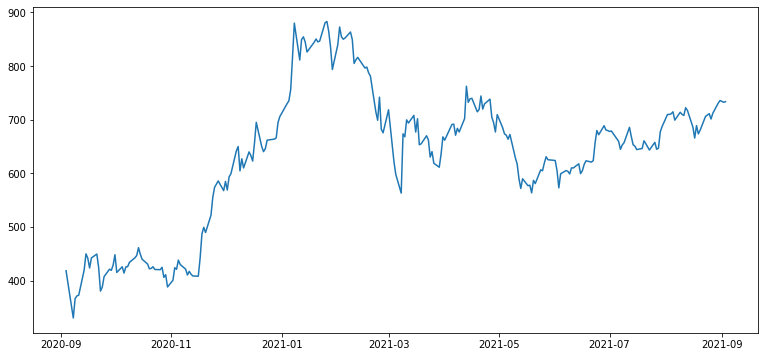

In [ ]:
plt.plot(ts_sb)

In [ ]:
ts_sb[ts_sb.isna()]

Series([], Name: Close, dtype: float64)

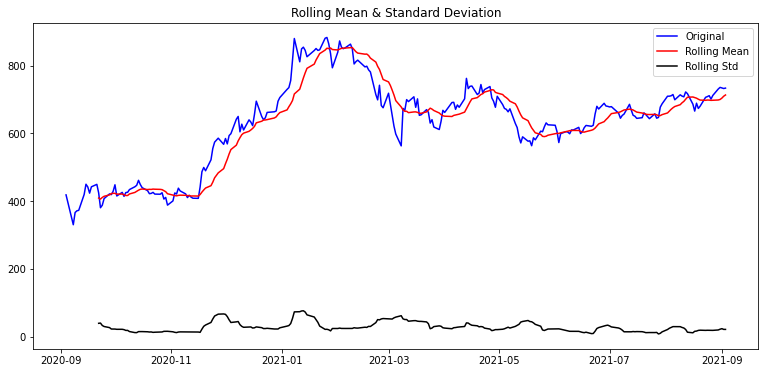

In [ ]:
plot_rolling_statistics(ts_sb)

In [ ]:
augmented_dickey_fuller_test(ts_sb)

Results of Dickey-Fuller Test:
Test Statistic                  -1.771682
p-value                          0.394609
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


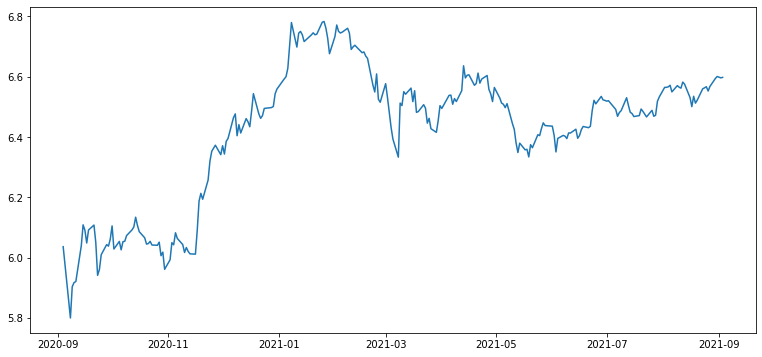

In [ ]:
ts_sb_log = np.log(ts_sb)

plt.plot(ts_sb_log)

In [ ]:
augmented_dickey_fuller_test(ts_sb_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.816222
p-value                          0.372438
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


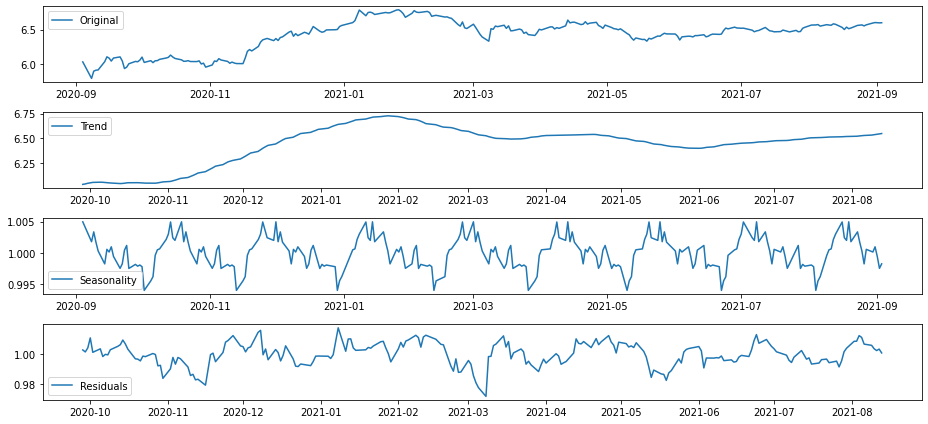

In [ ]:
decomposition = seasonal_decompose(ts_sb_log, model='multiplicative', freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_sb_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

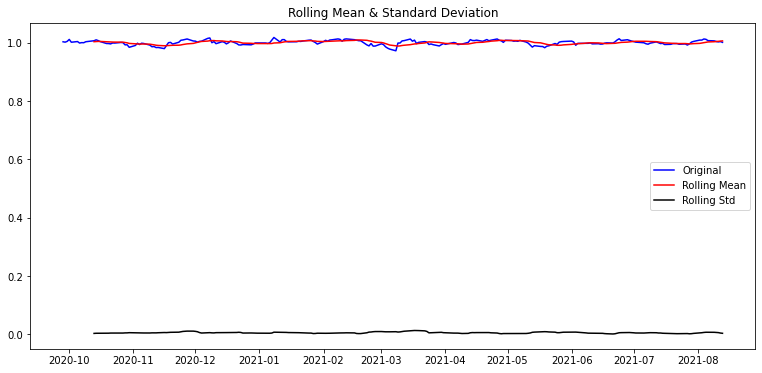

In [ ]:
plot_rolling_statistics(residual)

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.122206
p-value                          0.000013
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


#### Decomposing을 통해 얻어진 residual의 p-value가 0.05보다 훨씬 적다.

- 예측 가능한 수준의 안정적인 시계열이라고 판단할 수 있다.

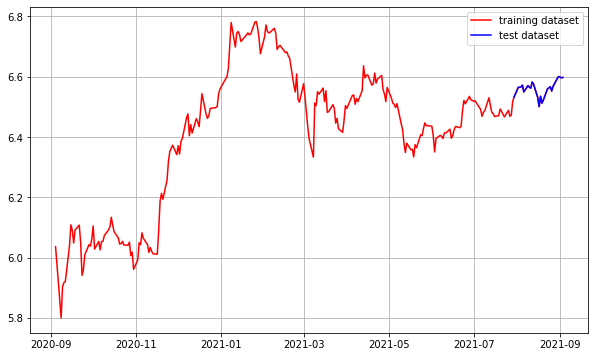

In [ ]:
train_sb, test_sb = ts_sb_log[:int(len(ts_sb_log)*0.9)], ts_sb_log[int(len(ts_sb_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_sb_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_sb, c='b', label='test dataset')
plt.legend()

In [ ]:
print(ts_sb_log[:2])
print(train_sb.shape)
print(test_sb.shape)

Date
2020-09-04    6.036247
2020-09-08    5.799729
Name: Close, dtype: float64
(226,)
(26,)


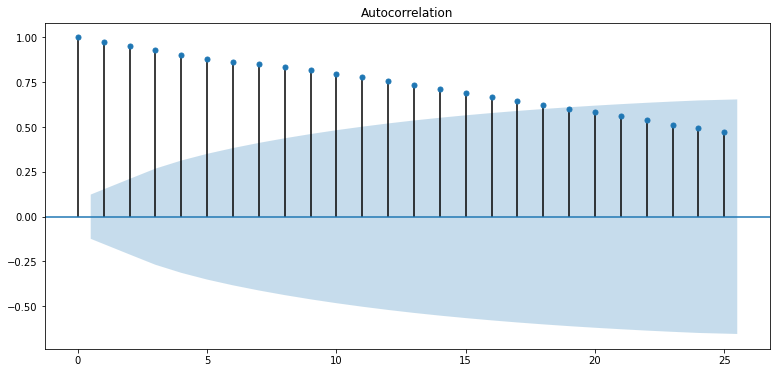

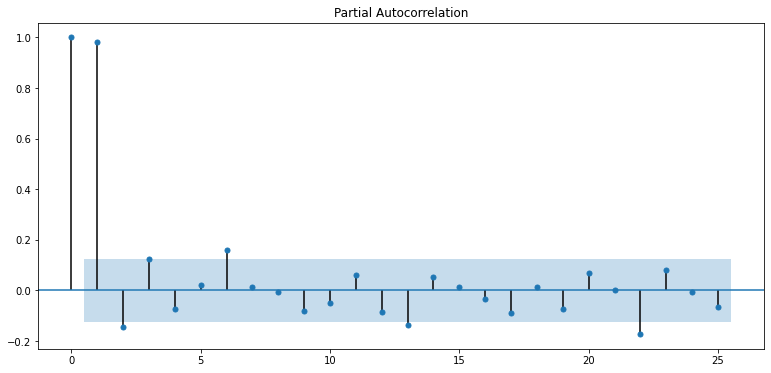

In [ ]:
plot_acf(ts_sb_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_sb_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.854141e+01
p-value                        2.097460e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


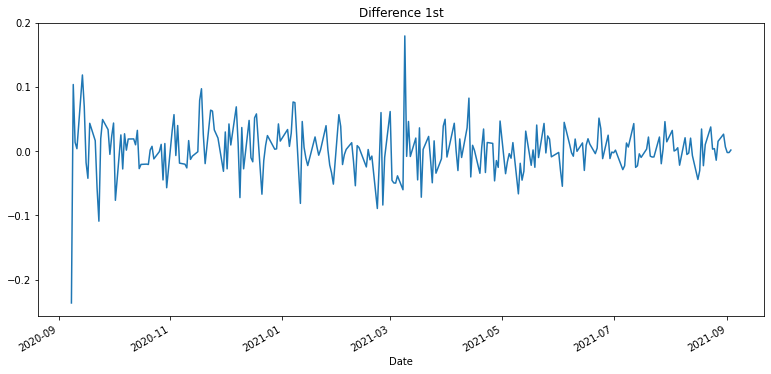

In [ ]:
# 1차 차분 구하기
diff_1 = ts_sb_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [ ]:
# Build Model
model_sb = ARIMA(train_sb, order=(1, 1, 0))  
fitted_m = model_sb.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 399.626
Method:                       css-mle   S.D. of innovations              0.041
Date:                Sun, 05 Sep 2021   AIC                           -793.251
Time:                        05:37:42   BIC                           -783.003
Sample:                             1   HQIC                          -789.115
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.002      0.896      0.371      -0.003       0.007
ar.L1.D.Close    -0.1015      0.072     -1.410      0.160      -0.243       0.040
                                    Root

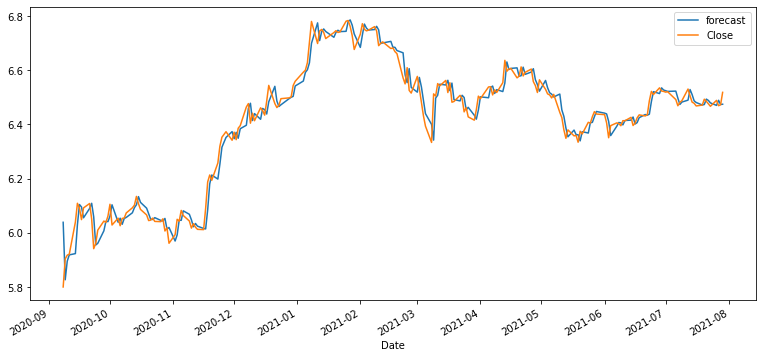

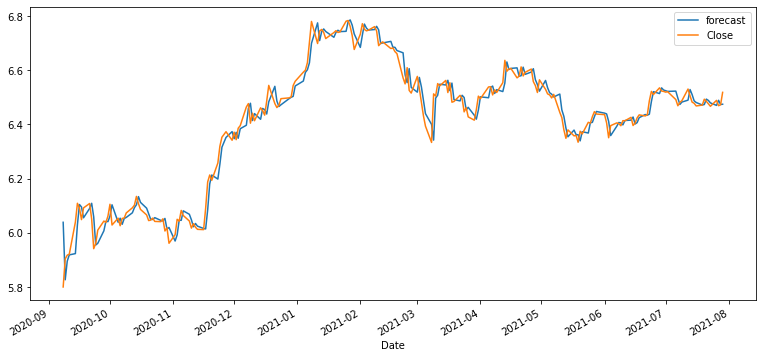

In [ ]:
fitted_m.plot_predict()

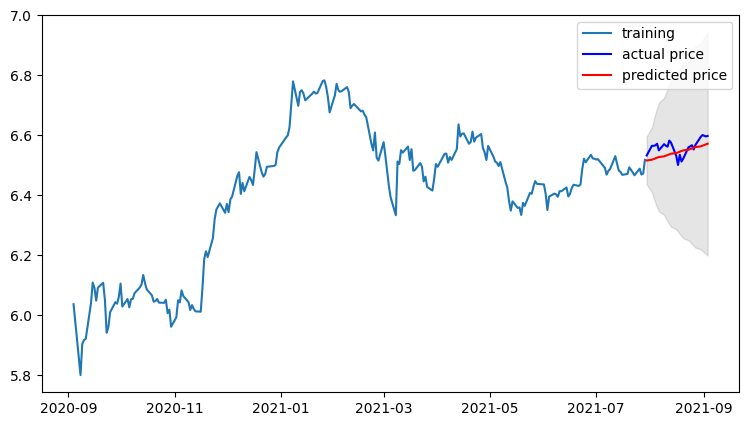

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_sb), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_sb.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_sb.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_sb.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_sb, label='training')
plt.plot(test_sb, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
# 로그 변환된 시계열을 지수 변환하여 원본 스케일로 되돌리고 모델의 오차율 계산
mse = mean_squared_error(np.exp(test_sb), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_sb), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_sb), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_sb))/np.abs(np.exp(test_sb)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  468.209015168942
MAE:  19.399905572527693
RMSE:  21.638137978322952
MAPE: 2.74%


## 내일의 나스닥

In [9]:
file_path = os.path.join(dir_path, 'NAS.csv')

df_nas = pd.read_csv(file_path, index_col='Date', parse_dates=True, error_bad_lines=False)
df_nas.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-08,10900.700195,11131.500000,10837.200195,10847.690430,10847.690430,3872230000
2020-09-09,11064.759766,11217.690430,10970.450195,11141.559570,11141.559570,3531780000
2020-09-10,11235.530273,11299.530273,10875.019531,10919.589844,10919.589844,3814100000
2020-09-11,11010.070313,11033.040039,10728.030273,10853.549805,10853.549805,3609190000
2020-09-14,11010.139648,11118.290039,10982.259766,11056.650391,11056.650391,3716820000


In [10]:
ts_nas = df_nas['Close']

ts_nas.head()

Date
2020-09-08    10847.690430
2020-09-09    11141.559570
2020-09-10    10919.589844
2020-09-11    10853.549805
2020-09-14    11056.650391
Name: Close, dtype: float64

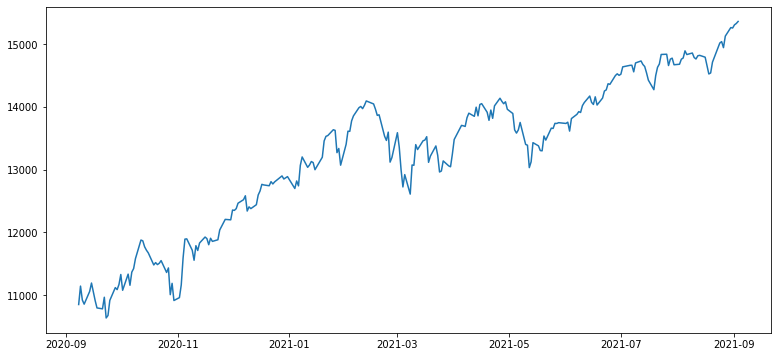

In [11]:
plt.plot(ts_nas)

In [12]:
ts_nas[ts_nas.isna()]

Series([], Name: Close, dtype: float64)

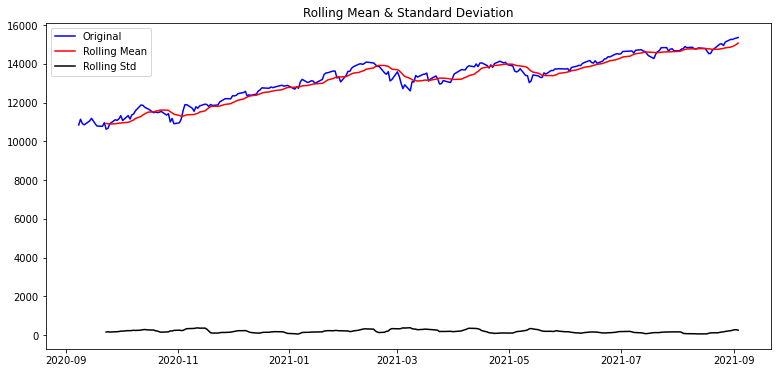

In [13]:
plot_rolling_statistics(ts_nas)

In [14]:
augmented_dickey_fuller_test(ts_nas)

Results of Dickey-Fuller Test:
Test Statistic                  -1.181061
p-value                          0.681689
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


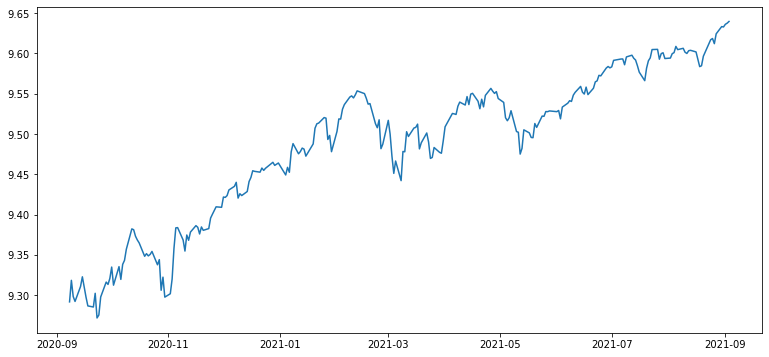

In [16]:
ts_nas_log = np.log(ts_nas)

plt.plot(ts_nas_log)

In [17]:
augmented_dickey_fuller_test(ts_nas_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.399214
p-value                          0.582653
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


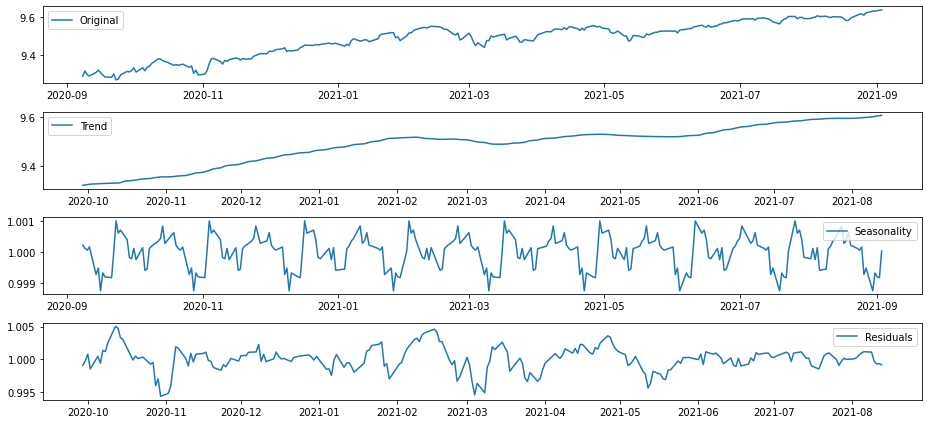

In [18]:
decomposition = seasonal_decompose(ts_nas_log, model='multiplicative', freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_nas_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

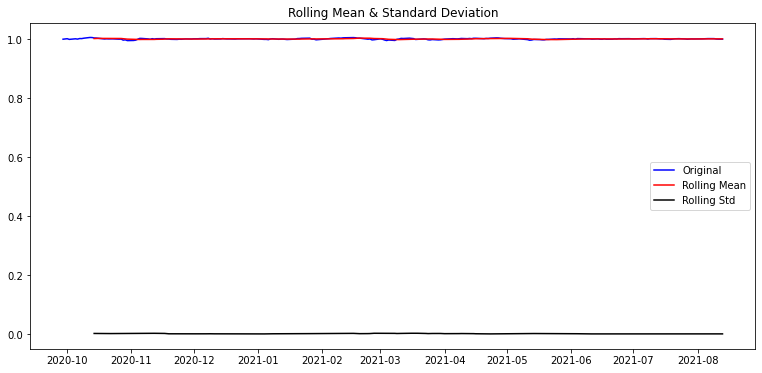

In [19]:
plot_rolling_statistics(residual)

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.519545
p-value                          0.000002
#Lags Used                       2.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


#### Decomposing을 통해 얻어진 residual의 p-value가 0.05보다 훨씬 적다.
- 예측 가능한 수준의 안정적인 시계열이라고 판단할 수 있다.

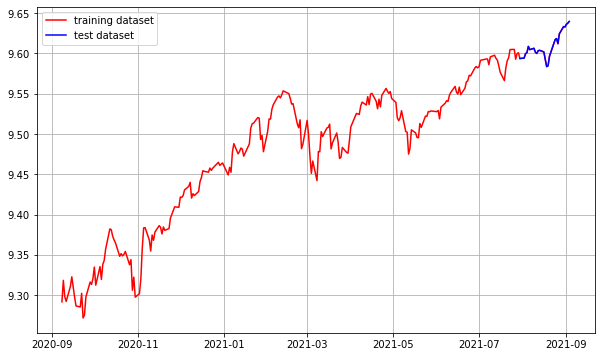

In [21]:
train_nas, test_nas = ts_nas_log[:int(len(ts_nas_log)*0.9)], ts_nas_log[int(len(ts_nas_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_nas_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_nas, c='b', label='test dataset')
plt.legend()

In [22]:
print(ts_nas_log[:2])
print(train_nas.shape)
print(test_nas.shape)

Date
2020-09-08    9.291707
2020-09-09    9.318438
Name: Close, dtype: float64
(225,)
(26,)


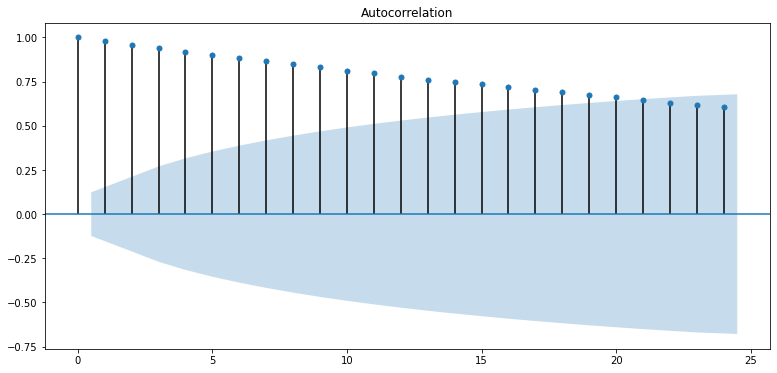

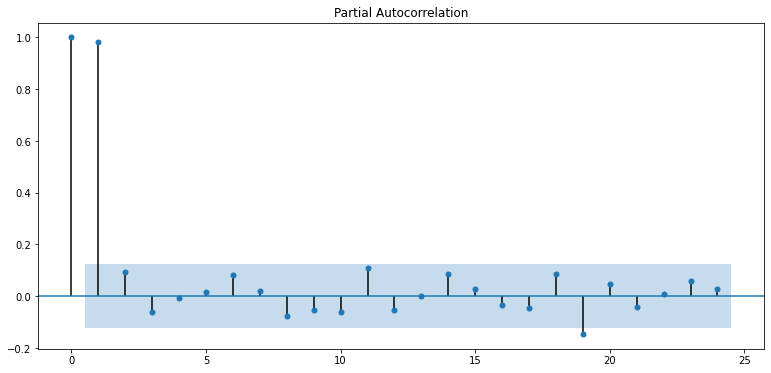

In [23]:
plot_acf(ts_nas_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_nas_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.743727e+01
p-value                        4.730808e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


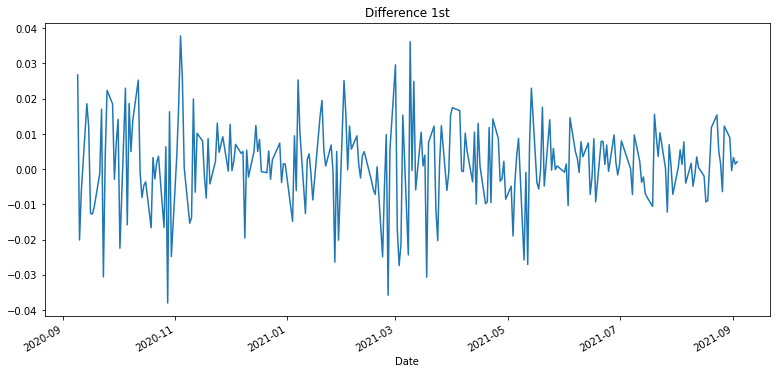

In [24]:
# 1차 차분 구하기
diff_1 = ts_nas_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [27]:
# Build Model
model_nas = ARIMA(train_nas, order=(1, 1, 0))  
fitted_m = model_nas.fit(disp=-1)

print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 663.394
Method:                       css-mle   S.D. of innovations              0.013
Date:                Sun, 05 Sep 2021   AIC                          -1320.788
Time:                        06:03:55   BIC                          -1310.553
Sample:                             1   HQIC                         -1316.656
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.812      0.071      -0.000       0.003
ar.L1.D.Close    -0.1075      0.067     -1.607      0.110      -0.239       0.024
                                    Root

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


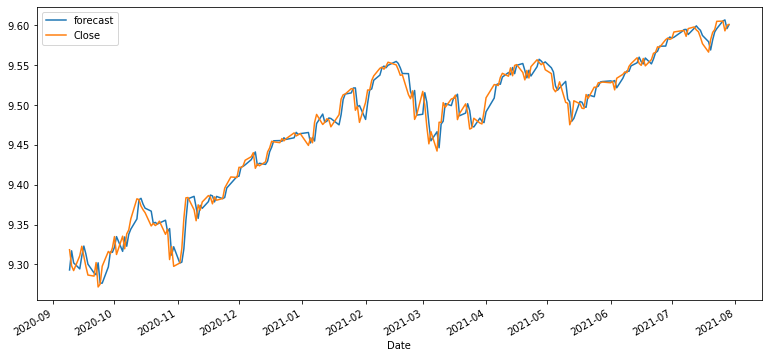

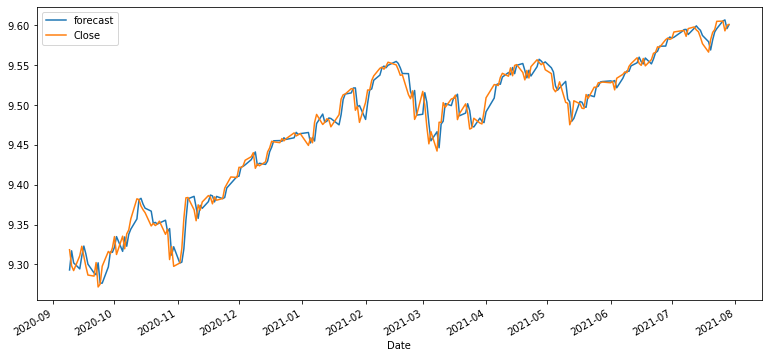

In [28]:
fitted_m.plot_predict()

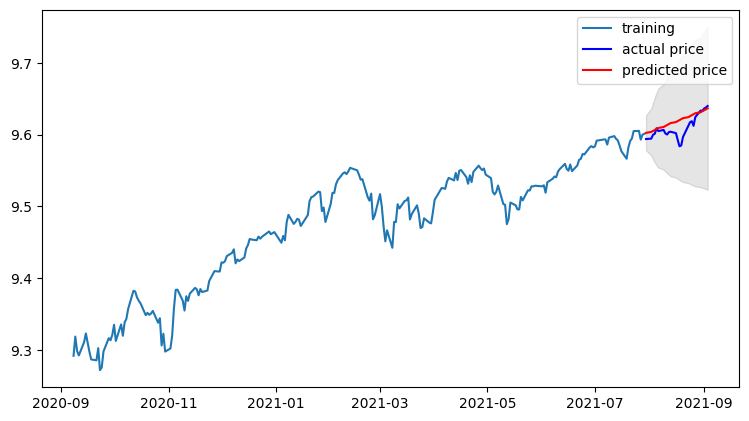

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_nas), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_nas.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_nas.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_nas.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_nas, label='training')
plt.plot(test_nas, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [30]:
# 로그 변환된 시계열을 지수 변환하여 원본 스케일로 되돌리고 모델의 오차율 계산
mse = mean_squared_error(np.exp(test_nas), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_nas), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_nas), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_nas))/np.abs(np.exp(test_nas)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  48417.99071092064
MAE:  164.60088963522796
RMSE:  220.04088418046462
MAPE: 1.12%
